# Import libraries

In [1]:
import numpy as np
import random
import operator
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats
import seaborn

# Parameters

In [2]:
i_max = 17          #Maximum number of epochs
c_max = 5           #Maximum number of acceptances
d_max = 4           #Maximum number of rejects

s0 = 1              #Initial solution (chosen to be between the limits of the optimal solutions [0, 2])
Tmax = 15.1773      #Initial temperature
Tmin = 0.01         #Final temperature
α = 0.65            #geometric schedule factor (between 0.5 and 0.99)
β = 0.7             #geometric schedule factor (between 0.5 and 0.99)

# Starting temperature

In [3]:
#Accept all

T0 = 100               #A random temperature high enough o accept all neighbours 

In [4]:
#Acceptance deviation

σ = 0.8222             #standard deviation of the differences between values of objective functions - found in prelim trials
p = 0.85               #acceptance probability (greater than 3σ and P>= 80%)
k = -3/ np.log(p)    

T0 = k*σ
T0

15.177308930242312

In [5]:
#Acceptance ratio

ΔE = -0.03846     #average of the objective function value degradations - found in prelim trials
a0 = 0.45         #acceptance rate (predetermined acceptance value) - usually between [40%, 50%]
m1 = 1            #the number of solutions to be increased - found in prelim trials
m2 = 12           #the number of solutions to be decreased - found in prelim trials

T0 = ΔE / (np.log(m1*(a0-1)/m2+a0))
T0

0.04245370751517293

# Cooling schedule

In [6]:
#Linear

def cooling_l(T0, epoch):

    Tnew = T0 - β*epoch 
    
    return Tnew

def heating_l(T0, epoch):
    
    Tnew = T0 + β*epoch 
    
    return Tnew

In [7]:
cool = []
for i in range(6):
    cool.append(cooling_l(15.1773, i))
    
print(cool)

[15.1773, 14.477300000000001, 13.7773, 13.077300000000001, 12.377300000000002, 11.6773]


In [8]:
#Geometric

def cooling_g(T):

    Tnew = α*T
    
    return Tnew

def heating_g(T):
    
    Tnew = T/α
    
    return Tnew

In [9]:
cool = []
T = 15.1773
temp = []
temp.append(T)
for i in range(6):
    cool.append(cooling_g(temp[i]))
    T = cooling_g(temp[i])
    temp.append(T)    
print(cool)

[9.865245000000002, 6.412409250000001, 4.168066012500001, 2.7092429081250007, 1.7610078902812505, 1.1446551286828128]


In [10]:
#Logarithmic

def cooling_log(T0, epoch):

    Tnew = T0 / np.log(epoch)
    
    return Tnew

def heating_log(T0):
    
    Tnew = T0 * np.log(epoch) 
    
    return Tnew

In [11]:
cool = []
for i in range(6):
    cool.append(cooling_log(15.1773, (i+1)))
    
print(cool)

[inf, 21.896215444084067, 13.8149738142835, 10.948107722042034, 9.430186702291598, 8.470612412356246]


C:\Users\F5331811\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in double_scalars
  """


## Objective functions

In [12]:
def F1(x):
    
    F1 = x**2
    
    return F1

def F2(x):
    
    F2 = (x-2)**2
    
    return F2

# Neighbourhood

In [13]:
def neighbour(x):
    
    M = (0.5 - random.random())*min(1, 2 - x, x)
    
    xnew = x + M
    
    return xnew

In [14]:
xnew = neighbour(0.55)
xnew

0.7247717123997776

# Dominates

In [15]:
def dominates(X1, X2):
    if(np.any(X1 < X2) and np.all(X1 <= X2)): 
        return True       #x1 will dominate x2 if all components of x1 are smaller than corresponding x2 components
    else:
        return False
    
def nondominated(X1, X2):
    if(np.any(X1 > X2) and np.any(X1 < X2)):   
        return True  #x1 and x2 are nondominating if one value of x1 is dominated by x2 and the othe value of x1 dominates x2
    else:
        return False
    
def dominance_relation(X1, X2):
    if(np.all(X1 == X2)):    #if the solutions have the same corresponding value, they are identical
        print("The solutions are identical.")
        return 1
    elif(dominates(X1, X2)):
        print("The first solution dominates the second.")
        return 2
    elif(nondominated(X1, X2)):
        print("The two solutions are nondominating")
        return 3
    else:                    #if x1 does not dominate x2 and they are not nondominating, then x1 is dominated by x2
        print("The first solution is dominated by the second.")
        return 4

# DBMOSA

In [16]:
x = 1
f1 = F1(s0)                                #the objective functions are calculated for the initial starting value
f2 = F2(s0)

T = 15.1773                                #the temperature is initialised as the calculated initial temperature

archive = np.array([f1, f2])               # the archive is set up to contain all of the current, non-dominated solutions 
A_til = archive                            #A tilda is set up to contain all of the solutions that have been accepted

t = 1                                      #the time step is initialised to 1
epoch = 0                                  #the epoch has been initialised to 0
c = 0                                      #the number of acceptances has been initialised to 0
d = 0                                      #the number of rejections has been initialised to 0

while epoch < i_max:                       #continue finding solutions while the nuber of epochs is lower than maximum

    if d == d_max:                  #if the number of rejections is at the maximum, increase the temperature and epoch count 

        T = heating_log(T0, epoch)
        epoch = epoch + 1
        c = 0
        d = 0

    if c == c_max:                 #if the number of acceptances is at the maximum, decrease the temperature and epoch count

        T = cooling_log(T0, epoch)
        epoch = epoch + 1
        c = 0
        d = 0
        
    x_new = neighbour(x)           #calculated what the neighbouring solution of the point is

    f1 = F1(x) 
    f2 = F2(x)
    
    f1_new = F1(x_new)             #find the objective functions of the new neighbour solution
    f2_new = F2(x_new)
    
    A_xdash = 0                    #calculate the number of solutions in A tilda that dominate x neighbour
    A_x = 0                        #calculate the number of solutions in A tilda that dominate x
    x_dash = []                    #calculate the index point of where x dominates the solution in the archive
    x_dash2 = []                   #calculate the index point of where x dominates the solution in A tilda
    
    for i in range(len(A_til)):
        dominance = dominance_relation([f1, f2], A_til[i])          #find the dominance between x and A tilda
        
        if dominance == 4:
            A_x = A_x + 1      #number of solutions in A tilda that dominate x
            
    for i in range(len(A_til)):
        dominance = dominance_relation([f1_new, f2_new], A_til[i])  #find the dominance between x neighbour and A tilda
        
        if dominance == 4:
            A_xdash = A_xdash + 1   #number of solutions in A tilda that dominate x neighbour
            
        if dominance == 2:
            x_dash2.append(i)       #the index point of where x dominates the solution in A tilda
            
    for i in range(len(archive)):
        dominance = dominance_relation([f1_new, f2_new], archive[i])   #find the dominance between x neighbour and the archive
            
        if dominance == 2:
            x_dash.append(i)        #the index point of where x dominates the solution in the archive
    
    new = np.array([f1_new, f2_new])   
    
    archive = np.vstack([archive, new])  #add the neighbour objective functions to the archive
    A_til = np.vstack([A_til, new])      #add the neighbour objective functions to A tilda
    
    num_A = len(A_til)                   #find the number of solutions in A tilda
    
    ΔE = (A_xdash - A_x) / num_A         #calculate the difference in energy based on the dominance of x and x neighbour
    
    archive = np.delete(archive, x_dash, 0)   #delete the point in the archive where x dominates the solution 
    A_til = np.delete(A_til, x_dash2, 0)      #delete the point in A tilda where x dominates the solution 
    
    P = min(1, np.exp(-1*ΔE/T))  #calculate the acceptance probobility of the solution based on the Metropolis acceptance rule
    limit = random.random()

    if P < limit:                  #if the acceptance probability is lower than a randomly generated number
        x = x                      #the x value stays the same and x neighbour is rejected
        t = t + 1                  #increase the time step
        d = d + 1                  #increase the number of rejections
        archive = archive[:-1]                #if the value is rejected it gets removed from the archive
        A_til = A_til[:-1]                    #if the value is rejected it gets removed from A tilda
        

    else:
        if A_xdash > 0: 
            archive = archive[:-1]
            #if the value is accepted but dominated, it does not go into the archive but still counts as a solution in A tilda
        x = x_new                 #the x neighbour solution becomes the next starting solution
        t = t + 1                 #increase the time step
        c = c + 1                 #increase the number of acceptances
        

The solutions are identical.
The solutions are identical.
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The solutions are identical.
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The solutions are identical.
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The solutions are identical.
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondo

C:\Users\F5331811\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """
C:\Users\F5331811\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:77: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\F5331811\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in double_scalars
  """



The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The solutions are identical.
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominatin

The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondom

The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondom

The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondom

The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The solutions are identical.
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating

The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondom

The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondom

The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondom

The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondom

The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondom

The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondom

The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The solutions are identical.
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating

The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondom

The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The solutions are identical.
The two solutions are nondominating
The two solutions are nondominating

The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondom

In [17]:
archive

array([[1.00000000e+00, 1.00000000e+00],
       [4.46243041e-01, 1.77418603e+00],
       [3.62994806e-01, 1.95303279e+00],
       [3.66371701e-01, 1.94522585e+00],
       [6.01840123e-01, 1.49870591e+00],
       [1.51686602e-01, 2.59380803e+00],
       [2.34346313e-01, 2.29797315e+00],
       [7.96659195e-02, 2.95065985e+00],
       [7.23525096e-02, 2.99641564e+00],
       [6.53586822e-02, 3.04274492e+00],
       [1.43576989e-01, 2.62791481e+00],
       [4.36149042e-02, 3.20824764e+00],
       [3.03782579e-02, 3.33320387e+00],
       [2.72518882e-02, 3.36692605e+00],
       [2.21743090e-02, 3.42653268e+00],
       [1.74770725e-02, 3.48867356e+00],
       [1.79692031e-02, 3.48177218e+00],
       [3.87104200e-02, 3.25171187e+00],
       [1.48234890e-02, 3.52781648e+00],
       [1.18082628e-02, 3.57714494e+00],
       [2.07439648e-02, 3.44463335e+00],
       [4.43056074e-02, 3.20234972e+00],
       [5.94754085e-02, 3.08397219e+00],
       [2.49271401e-02, 3.39339389e+00],
       [1.983944

In [18]:
np.std(np.abs(archive[:, 0] - archive[:, 1]))

0.931674923618114

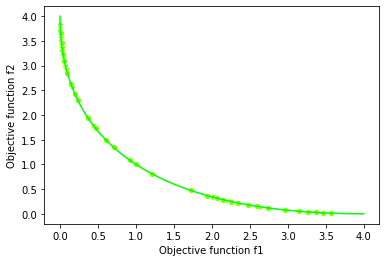

In [19]:
x = np.linspace(0, 2, 50)
f1 = F1(x)
f2 = F2(x)

c = seaborn.scatterplot(archive[:, 0], archive[:, 1] , color = 'chartreuse')
c = seaborn.lineplot(f1, f2, color = 'lime')


c.set_xlabel("Objective function f1")
c.set_ylabel("Objective function f2")
plt.savefig('Pareto2.png', transparent=True)



In [20]:
x = np.sqrt(archive[:, 0])
x

array([1.        , 0.66801425, 0.6024905 , 0.60528646, 0.77578355,
       0.38946964, 0.48409329, 0.28225152, 0.26898422, 0.25565344,
       0.37891554, 0.20884182, 0.1742936 , 0.16508146, 0.14891041,
       0.13220088, 0.13404926, 0.19674964, 0.12175175, 0.10866583,
       0.14402765, 0.21048897, 0.24387581, 0.15788331, 0.14085257,
       0.18075947, 0.16387424, 0.18102842, 0.09237485, 0.04675334,
       0.06210951, 0.07134335, 0.06278705, 0.07007716, 0.08879228,
       0.12169459, 0.18124028, 0.11250621, 0.07453068, 0.05830055,
       0.08272828, 0.07868738, 0.10865367, 0.06939328, 0.08951647,
       0.11142947, 0.15840412, 0.10400112, 0.09955407, 0.07287224,
       0.07482246, 0.1025818 , 0.08876108, 0.12957742, 0.14284646,
       0.20315032, 0.24252726, 0.3092568 , 0.44315723, 0.4853303 ,
       0.68456315, 0.95698598, 0.83957734, 1.09959712, 1.31109234,
       1.46437618, 1.41913372, 1.52454498, 1.48903807, 1.49690937,
       1.61787374, 1.43960886, 1.60842595, 1.6560592 , 1.50162

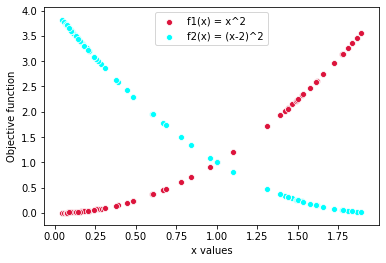

In [21]:
b = seaborn.scatterplot(x, archive[:, 0], color = 'crimson', label = "f1(x) = x^2")
b = seaborn.scatterplot(x, archive[:, 1], color = 'cyan',label = "f2(x) = (x-2)^2")

b.legend()
b.set_xlabel("x values")
b.set_ylabel("Objective function")

plt.savefig('Objective2.png', transparent=True)

# Theoretical

In [22]:
x = np.linspace(-4, 4, 50)
f1 = F1(x)
f2 = F2(x)

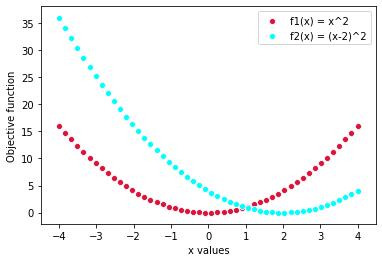

In [23]:
a = seaborn.scatterplot(x, f1, color = 'crimson', label = "f1(x) = x^2")
a = seaborn.scatterplot(x, f2, color = 'cyan', label = "f2(x) = (x-2)^2")

a.legend()
a.set_xlabel("x values")
a.set_ylabel("Objective function")
plt.savefig('Actual Objective.png', transparent=True)


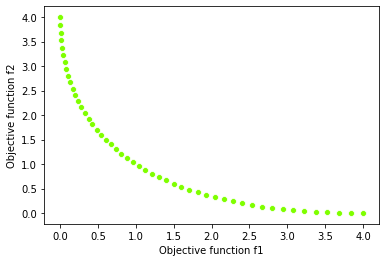

In [24]:
x = np.linspace(0, 2, 50)
f1 = F1(x)
f2 = F2(x)

p = seaborn.scatterplot(f1, f2, color = 'chartreuse')

p.set_xlabel("Objective function f1")
p.set_ylabel("Objective function f2")
plt.savefig('True Pareto.png', transparent=True)

# Kernel method

In [25]:
def Kernel(x, archive):  
    
    σ = 0.01                              #choose the non-similarity threshold from empirical analysis
    S = []
    x1 = [F1(x), F2(x)]                   #calculate the objective functions
    total = len(archive)

    for i in range(total):
        print(archive[i])
        
        d = np.sqrt((x1[0] - archive[i, 0])**2 + (x1[1] - archive[i, 1])**2)     
        
        #calculate the distance between the new solution and the archived solutions
        
        if d < σ:                        #if the distance is lower than the non-similarity threshold 
            S.append(1 - (d/ σ))

        else:
            S.append(0)
            
    m = sum(S)
    if m == 0:
        return f1_new, f2_new
    
    else:
        
        f1 = f1_new/m
        f2 = f2_new/m
    
        return f1, f2

In [26]:
x = 1
f1 = F1(s0)                                #the objective functions are calculated for the initial starting value
f2 = F2(s0)

T = 15.1773                                #the temperature is initialised as the calculated initial temperature

archive = np.array([f1, f2])               # the archive is set up to contain all of the current, non-dominated solutions 
A_til = archive                            #A tilda is set up to contain all of the solutions that have been accepted

t = 1                                      #the time step is initialised to 1
epoch = 0                                  #the epoch has been initialised to 0
c = 0                                      #the number of acceptances has been initialised to 0
d = 0                                      #the number of rejections has been initialised to 0

while epoch < i_max:                       #continue finding solutions while the nuber of epochs is lower than maximum
    
    print(archive)

    if d == d_max:                  #if the number of rejections is at the maximum, increase the temperature and epoch count 

        T = heating_log(T0, epoch+1)
        epoch = epoch + 1
        c = 0
        d = 0

    if c == c_max:                 #if the number of acceptances is at the maximum, decrease the temperature and epoch count

        T = cooling_log(T0, epoch+1)
        epoch = epoch + 1
        c = 0
        d = 0
        
    x_new = neighbour(x)           #calculated what the neighbouring solution of the point is

    f1 = F1(x) 
    f2 = F2(x)
    
    f1_new = F1(x_new)             #find the objective functions of the new neighbour solution
    f2_new = F2(x_new)
    
    
    new = np.array([f1_new, f2_new]) 
    
    archive = np.vstack([archive, new])  #add the neighbour objective functions to the archive
    A_til = np.vstack([A_til, new])      #add the neighbour objective functions to A tilda
    diversity = Kernel(x_new, archive)
    
    f1_new = diversity[0]
    f2_new = diversity[1]
    
    A_xdash = 0                    #calculate the number of solutions in A tilda that dominate x neighbour
    A_x = 0                        #calculate the number of solutions in A tilda that dominate x
    x_dash = []                    #calculate the index point of where x dominates the solution in the archive
    x_dash2 = []                   #calculate the index point of where x dominates the solution in A tilda
    
    for i in range(len(A_til)):
        dominance = dominance_relation([f1, f2], A_til[i])          #find the dominance between x and A tilda
        
        if dominance == 4:
            A_x = A_x + 1      #number of solutions in A tilda that dominate x
            
    for i in range(len(A_til)):
        dominance = dominance_relation([f1_new, f2_new], A_til[i])  #find the dominance between x neighbour and A tilda
        
        if dominance == 4:
            A_xdash = A_xdash + 1   #number of solutions in A tilda that dominate x neighbour
            
        if dominance == 2:
            x_dash2.append(i)       #the index point of where x dominates the solution in A tilda
            
    for i in range(len(archive)):
        dominance = dominance_relation([f1_new, f2_new], archive[i])   #find the dominance between x neighbour and the archive
            
        if dominance == 2:
            x_dash.append(i)        #the index point of where x dominates the solution in the archive
    

    num_A = len(A_til)                   #find the number of solutions in A tilda
    
    ΔE = (A_xdash - A_x) / num_A         #calculate the difference in energy based on the dominance of x and x neighbour
    
    archive = np.delete(archive, x_dash, 0)   #delete the point in the archive where x dominates the solution 

    A_til = np.delete(A_til, x_dash2, 0)      #delete the point in A tilda where x dominates the solution 
    
    P = min(1, np.exp(-1*ΔE/T))  #calculate the acceptance probobility of the solution based on the Metropolis acceptance rule
    limit = random.random()

    if P < limit:                  #if the acceptance probability is lower than a randomly generated number
        x = x                      #the x value stays the same and x neighbour is rejected
        t = t + 1                  #increase the time step
        d = d + 1                  #increase the number of rejections
        archive = archive[:-1]                #if the value is rejected it gets removed from the archive
        A_til = A_til[:-1]                    #if the value is rejected it gets removed from A tilda
        

    else:
        if A_xdash > 0: 
            archive = archive[:-1]
            #if the value is accepted but dominated, it does not go into the archive but still counts as a solution in A tilda
        x = x_new                 #the x neighbour solution becomes the next starting solution
        t = t + 1                 #increase the time step
        c = c + 1                 #increase the number of acceptances
        

[1 1]
[1. 1.]
[0.6421236 1.436819 ]
The solutions are identical.
The two solutions are nondominating
The two solutions are nondominating
The solutions are identical.
The two solutions are nondominating
The solutions are identical.
[[1.        1.       ]
 [0.6421236 1.436819 ]]
[1. 1.]
[0.6421236 1.436819 ]
[1.25664086 0.77264111]
The two solutions are nondominating
The solutions are identical.
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The solutions are identical.
The two solutions are nondominating
The two solutions are nondominating
The solutions are identical.
[[1.         1.        ]
 [0.6421236  1.436819  ]
 [1.25664086 0.77264111]]
[1. 1.]
[0.6421236 1.436819 ]
[1.25664086 0.77264111]
[1.40218292 0.66563072]
The two solutions are nondominating
The two solutions are nondominating
The solutions are identical.
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
Th

C:\Users\F5331811\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in double_scalars
  """


The two solutions are nondominating
The two solutions are nondominating
The solutions are identical.
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The solutions are identical.
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The solutions are identical.
[[0.6421236  1.436819  ]
 [1.63220284 0.52189508]
 [2.99019796 0.07332241]
 [2.80143188 0.10644046]
 [2.35062554 0.21792559]
 [1.99584942 0.34486803]
 [2.507

[[6.42123601e-01 1.43681900e+00]
 [1.63220284e+00 5.21895076e-01]
 [3.71890039e+00 5.12010791e-03]
 [3.78353195e+00 3.01068219e-03]
 [3.74878208e+00 4.07335215e-03]
 [3.73484162e+00 4.54628787e-03]]
[0.6421236 1.436819 ]
[1.63220284 0.52189508]
[3.71890039 0.00512011]
[3.78353195e+00 3.01068219e-03]
[3.74878208 0.00407335]
[3.73484162 0.00454629]
[3.83943544e+00 1.64448594e-03]
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The solutions are identical.
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The solutions are identical.
The two solutions are nondominating
The two solutions are nondominating
The two solutions are nondominating
The two solutions are

In [27]:
archive

array([[6.42123601e-01, 1.43681900e+00],
       [1.63220284e+00, 5.21895076e-01],
       [3.89087833e+00, 7.54548903e-04],
       [3.94352050e+00, 2.00790981e-04],
       [3.91714584e+00, 4.33552726e-04]])

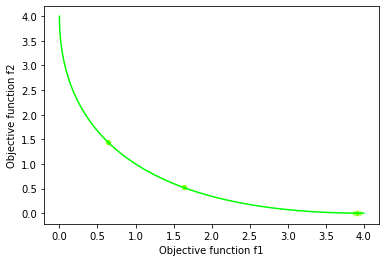

In [28]:
x = np.linspace(0, 2, 50)
f1 = F1(x)
f2 = F2(x)

c = seaborn.scatterplot(archive[:, 0], archive[:, 1] , color = 'chartreuse')
c = seaborn.lineplot(f1, f2, color = 'lime')


c.set_xlabel("Objective function f1")
c.set_ylabel("Objective function f2")
plt.savefig('Pareto Kernel.png', transparent=True)

In [29]:
x = np.sqrt(archive[:, 0])
x

array([0.80132615, 1.27757694, 1.97253095, 1.98582993, 1.97917807])

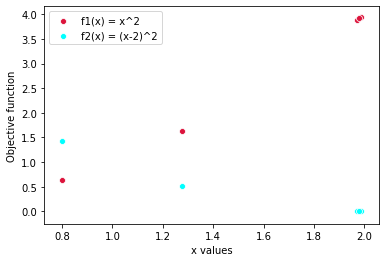

In [30]:
b = seaborn.scatterplot(x, archive[:, 0], color = 'crimson', label = "f1(x) = x^2")
b = seaborn.scatterplot(x, archive[:, 1], color = 'cyan',label = "f2(x) = (x-2)^2")

b.legend()
b.set_xlabel("x values")
b.set_ylabel("Objective function")

plt.savefig('Objective Kernel.png', transparent=True)